In [2]:
import yfinance as yf
import pandas as pd

ticker = 'AAPL'

# Fetch data
stock_data = yf.download(ticker, start='2015-01-01', end='2023-12-31', auto_adjust=False)

[*********************100%***********************]  1 of 1 completed


In [3]:
print(stock_data.info()) # data types
print(stock_data.describe()) # summary statistics

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2264 entries, 2015-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, AAPL)  2264 non-null   float64
 1   (Close, AAPL)      2264 non-null   float64
 2   (High, AAPL)       2264 non-null   float64
 3   (Low, AAPL)        2264 non-null   float64
 4   (Open, AAPL)       2264 non-null   float64
 5   (Volume, AAPL)     2264 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB
None
Price     Adj Close        Close         High          Low         Open  \
Ticker         AAPL         AAPL         AAPL         AAPL         AAPL   
count   2264.000000  2264.000000  2264.000000  2264.000000  2264.000000   
mean      81.566078    84.026440    84.876609    83.092088    83.956509   
std       56.108762    56.034699    56.611354    55.396020    55.979856   
min       20.647457    22.584999    22.917500    22.367500  

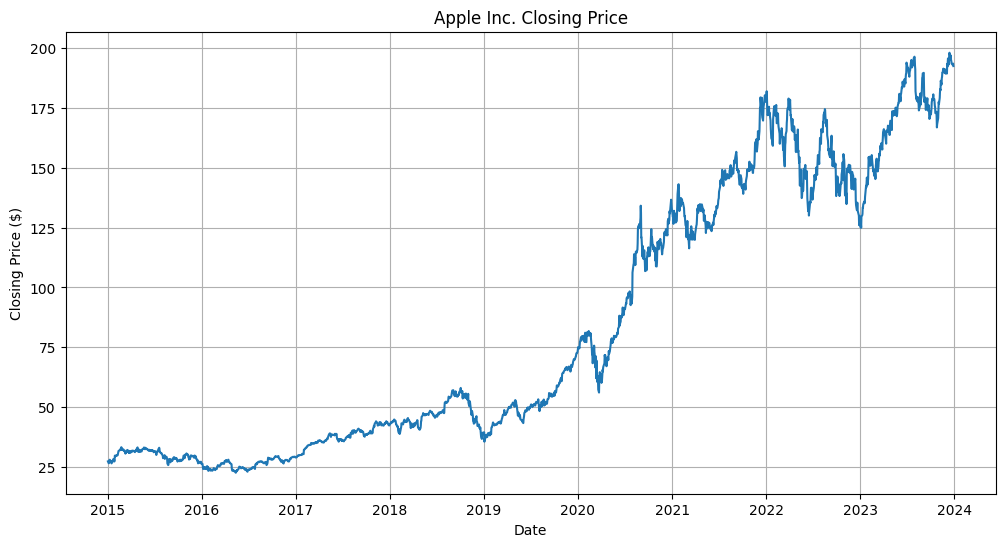

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(stock_data['Close'])
plt.title('Apple Inc. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.grid(True)
plt.show()

In [6]:
# Check for missing values
print(stock_data.isnull().sum())

Price      Ticker
Adj Close  AAPL      0
Close      AAPL      0
High       AAPL      0
Low        AAPL      0
Open       AAPL      0
Volume     AAPL      0
dtype: int64


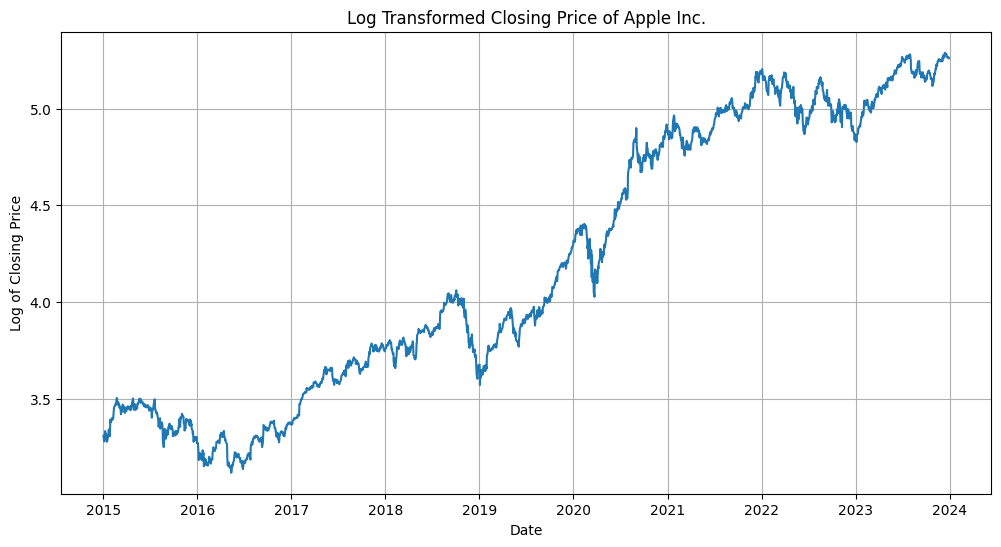

In [7]:
import numpy as np

df_close = stock_data['Close']

# Apply log transformation
df_log = np.log(df_close)

plt.figure(figsize=(12,6))
plt.plot(df_log)
plt.title('Log Transformed Closing Price of Apple Inc.')
plt.xlabel('Date')
plt.ylabel('Log of Closing Price')
plt.grid(True)
plt.show()

In [8]:
print(df_close.describe())

Ticker         AAPL
count   2264.000000
mean      84.026440
std       56.034699
min       22.584999
25%       35.439376
50%       53.868752
75%      141.710003
max      198.110001


1. 25%-50%-75% quartiles show wide jump from 53→141
2. Skewed distribution
    1. mean (84.03) is higher than median (53.87), indicating right skewness (tail towards high prices)
3. High Variability
    1. standard deviation of 56 is 66% of the mean, showing high volatility - typical for long term stock data

<Figure size 1200x600 with 0 Axes>

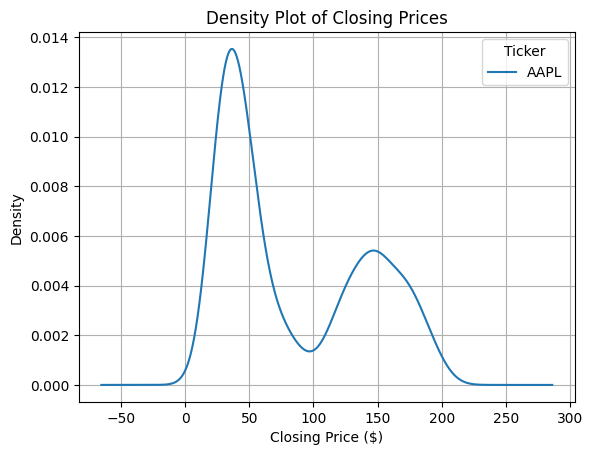

In [9]:
# Density plot
plt.figure(figsize=(12,6))
df_close.plot(kind='kde')
plt.title('Density Plot of Closing Prices')
plt.xlabel('Closing Price ($)')
plt.grid(True)
plt.show()

1. Kernel Density Estimation (KDE)
    1. KDE is a smoothed version of a histogram, estimating the probability density function (PDF) of the variable
    2. Density doesn’t represent probability directly but the area under the curve sums to 1, so it tells us how “common” different price ranges are
2. Observations
    1. Bimodal
        1. Two distinct peaks
        2. suggests stock price spent a lot of time in these two regions
    2. Left tail
        1. long left tail extending below 0, likely due to KDE bandwidth smoothing over into negative territory
    3. Wide price range
        1. significant price growth over time

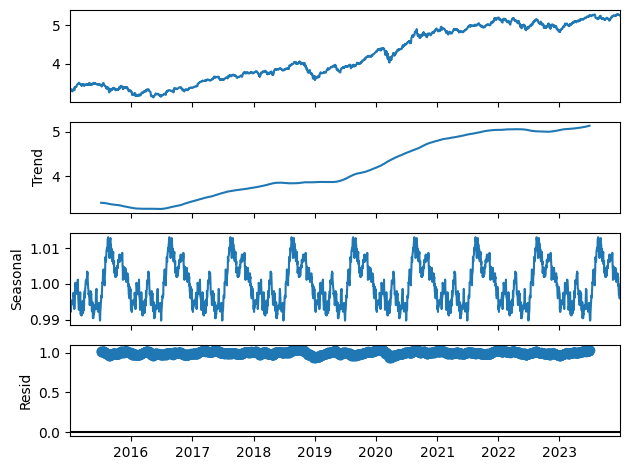

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series
result = seasonal_decompose(df_log, model='multiplicative', period=252)  # Approximate trading days in a year

# Plot decomposition
result.plot()
plt.show()


1. Log-transformed time series
2. Trend
    1. Upward trend
    2. There are plateaus or slowdowns in some periods
3. Seasonal
    1. Isolated repeating patterns that occur with a fixed period (period =252)
    2. Fluctuates slightly around 1 (since its multiplicative)
    3. suggests a mild but consistent season effect perhaps related to calendar based patterns like quarterly earnings, fiscal cycles
4. Residual (Noise)
    1. This is what’s left over after removing trend and seasonality
    2. ideally this should look like white noise - no trend or seasonality
    3. residuals are centered close to 1 (due to multiplicative) and appear relatively stable
    4. some variance remains,
5. Conclusion
    1. Strong trend, mild seasonality, and low residual noise

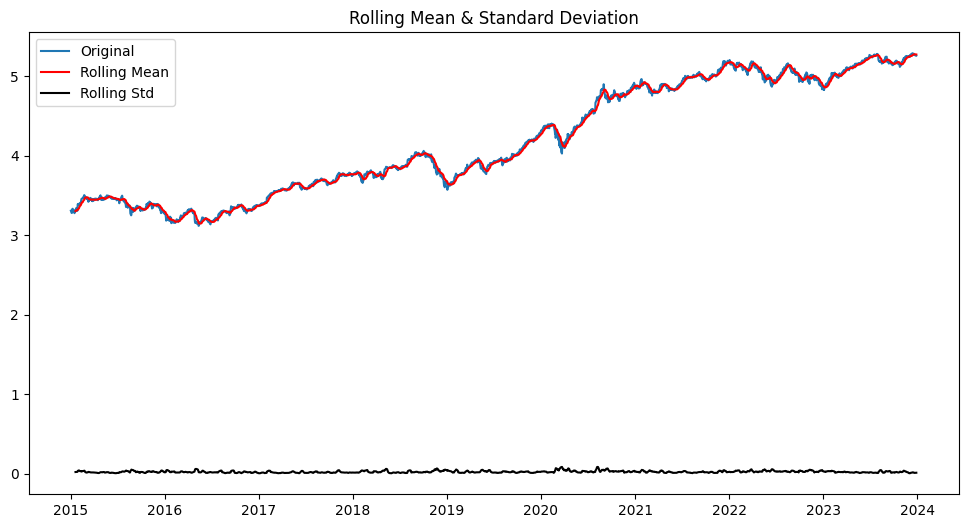

Results of Augmented Dickey-Fuller Test:
Test Statistic                   -0.369502
p-value                           0.915068
#Lags Used                        9.000000
Number of Observations Used    2254.000000
Critical Value (1%)              -3.433255
Critical Value (5%)              -2.862823
Critical Value (10%)             -2.567453
dtype: float64


In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics
    plt.figure(figsize=(12,6))
    plt.plot(timeseries, label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend()
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform ADF test
    print('Results of Augmented Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in adf_test[4].items():
        adf_output['Critical Value (%s)' % key] = value
    print(adf_output)

# Test stationarity
test_stationarity(df_log)


1. Visually, not stationary,
    1.  rolling mean shows a clear upward trend, not staying constant over time
    2. rolling std shows slight fluctuations but generally stays low and flat, which is good but not enough
2. Null hypothesis that data is non-stationary fails to get rejected, so time series is non-stationary
    1. p-value > 0.05
    2. test statistic > critical values

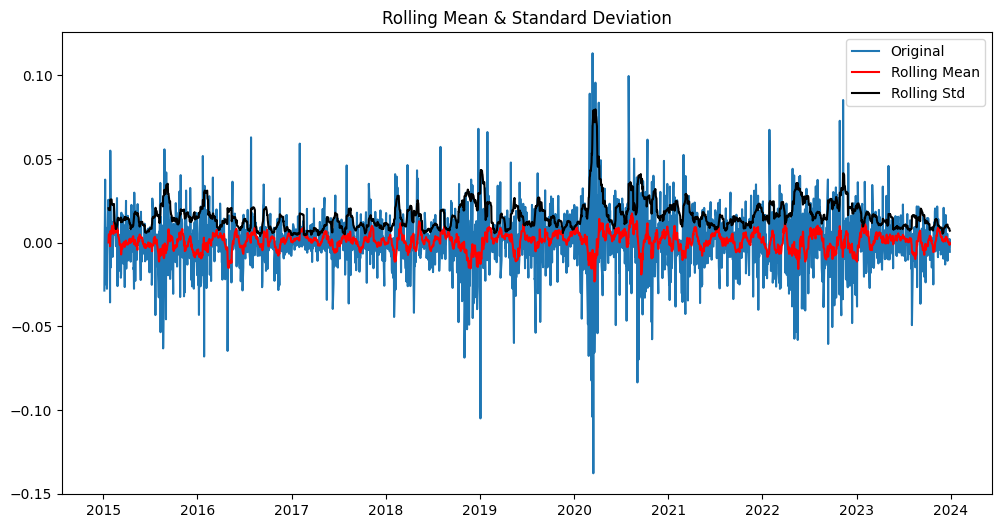

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.473359e+01
p-value                        2.636491e-27
#Lags Used                     8.000000e+00
Number of Observations Used    2.254000e+03
Critical Value (1%)           -3.433255e+00
Critical Value (5%)           -2.862823e+00
Critical Value (10%)          -2.567453e+00
dtype: float64


In [12]:
# Differencing
df_log_diff = df_log.diff().dropna()

# Test stationarity again
test_stationarity(df_log_diff)

1. Rolling mean, almost flat around zero, good
2. rolling std, mostly constant over time, good
3. test statistic very negative and p-value < 0.05 -> reject null

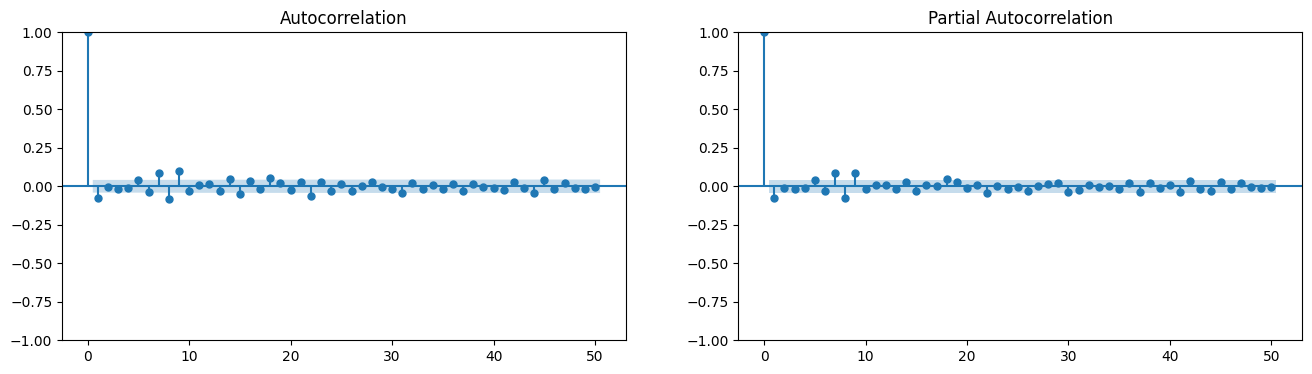

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(df_log_diff, lags=50, ax=axes[0])
plot_pacf(df_log_diff, lags=50, ax=axes[1])
plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11689.862, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11680.731, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11691.461, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11691.692, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11677.710, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11689.792, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11687.956, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-11687.776, Time=0.13 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 1.029 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2264
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5848.846
Date:                Tue, 20 May 2025   AIC                         -11691.692
Time:               

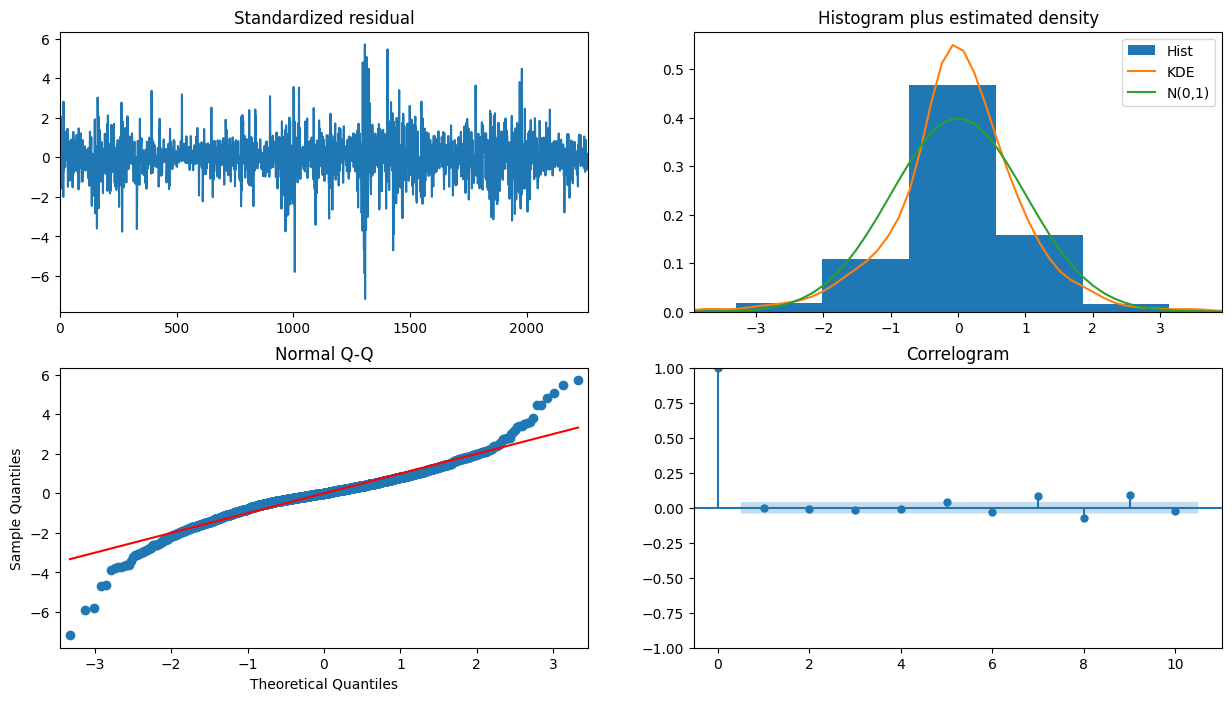

In [15]:
import pmdarima as pm
import warnings
warnings.filterwarnings("ignore")

# Auto ARIMA
model_autoARIMA = pm.auto_arima(df_log, start_p=1, start_q=1,
                                test='adf',       # use adf test to find optimal 'd'
                                max_p=5, max_q=5, # maximum p and q
                                m=1,              # frequency of series
                                d=None,           # let model determine 'd'
                                seasonal=False,   # No Seasonality
                                start_P=0,
                                D=0,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True)

print(model_autoARIMA.summary())

# Plot diagnostics
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


Standardized Residuals
1. Randomly scattered around zero → good
2. Some spikes

Histogram
1. y-axis = density
2. Hist = Histogram of residuals
3. KDE = smoothed version of histogram
4. N(0,1) = Theoretical normal distribution curve
5. Residuals are approximately normal, but slight leptokurtosis (high peaks and fatter tails than normal)
6. Slight skew left (confirmed by Jarque-Bera score of 2350.16)

Normal Q-Q
Deviations from red tail at tails → suggests non-normal residuals (heavy tails)

Correlogram
1. Most autocorrelations are inside the confidence bands
2. Ljung-Box p-value = 1.00 → residuals are white noise

Coefficients
- intercept 0.0009 Small positive drift (average daily log return = 0.09%)
- ma.L1 -0.0758 slight short-term noise correction
- Variance 0.0003 low variance of residuals

Summary
- AIC, lower is better → strong model
- JB, 2350.16 (p =0.00) → Reject normality (heavy tails)
- Heteroskedasticity (H) 1.46 (p = 0.00) → variance not constant
    - volatility clustering (GARCH may help)

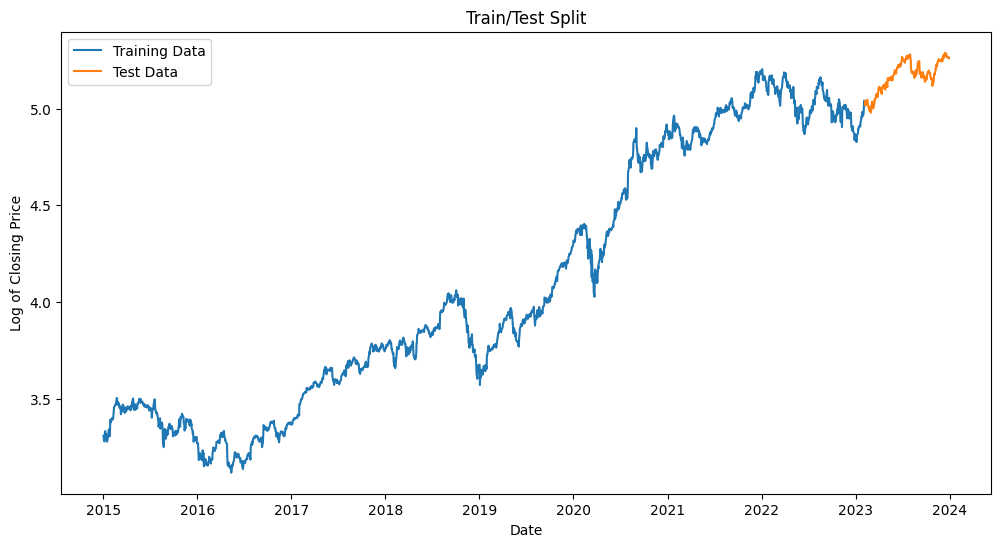

In [16]:
# Split data
train_size = int(len(df_log) * 0.9)
train_data, test_data = df_log[:train_size], df_log[train_size:]

# Plot training and testing data
plt.figure(figsize=(12,6))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data')
plt.title('Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Log of Closing Price')
plt.legend()
plt.show()

In [17]:
from statsmodels.tsa.arima.model import ARIMA

# Build and fit the model
model = ARIMA(train_data, order=model_autoARIMA.order)
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                 2037
Model:                 ARIMA(0, 1, 1)   Log Likelihood                5198.917
Date:                Tue, 20 May 2025   AIC                         -10393.834
Time:                        19:52:27   BIC                         -10382.597
Sample:                             0   HQIC                        -10389.712
                               - 2037                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0788      0.015     -5.421      0.000      -0.107      -0.050
sigma2         0.0004   6.42e-06     55.175      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

Term	Meaning
AR = 0	No autoregressive (lagged value) terms
I = 1	First-order differencing (working on log returns)
MA = 1	One moving average term (lagged error correction)

Metric	        Value	    Interpretation
Log Likelihood	5198.92	    Used to compute AIC/BIC
AIC	            -10393.83	Lower = better model fit
BIC	            -10382.60   Similar to AIC but penalizes complexity more
HQIC	        -10389.71	Like AIC, used for model comparison

📈 Coefficients Table
Parameter	Value   p-value	 Notes
ma.L1	    -0.0788	0.000	 Significant (p < 0.05) — MA(1) term is needed
sigma2	     0.0004	0.000	 Variance of residuals — small, as expected for log returns


🧪 Ljung-Box Q-test
Prob(Q) = 0.92 → Residuals look like white noise (no auto correlation left)

🧪 Jarque-Bera Test
JB = 1935.21, p = 0.00 → Residuals are not normally distributed (heavy tails)

🧪 Heteroskedasticity (H) test
H = 1.92, p = 0.00 → ❌ Residuals have non-constant variance


🔍 Skew & Kurtosis
Skew = -0.26 → Slightly left-skewed
Kurtosis = 7.75 → Much higher than 3 → leptokurtic (fat tails)

This again confirms financial return behavior (not i.i.d. normal).

| Aspect           | Status                                                  |
|------------------|---------------------------------------------------------|
| Fit quality      | ✅ Excellent (very low AIC)                              |
| MA coefficient   | ✅ Significant                                           |
| Residuals        | ✅ Uncorrelated (white noise)                            |
| Normality        | ❌ Not perfect (but expected in finance)                 |
| Homoscedasticity | ❌ Fails (consider GARCH if modeling volatility matters) |
